In [1]:
tf.config.list_physical_devices('GPU')

NameError: name 'tf' is not defined

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from attention_layer import AttentionLayer

In [4]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
import nltk
nltk.download("stopwords")
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Science\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#load 10k reviews:
data_reviews={}
len_reviews = 10000
with open("data/reviews_Kindle_Store_5.json","r") as reader:
    for i in range(len_reviews):
        line = reader.readline()
        if line =="":
            print(f"Reached EOF at {i}")
            break
        json_line = json.loads(line)
        # Too short
        if len(json_line["reviewText"]) < 50:
            continue
        if json_line["asin"] in data_reviews:
            data_reviews[json_line["asin"]].append('sostock '+  json_line["reviewText"] + ' eostock')
        else:
            data_reviews[json_line["asin"]] = ['sostock '+ json_line["reviewText"] + ' eostock']


In [6]:
# Delete those asins, with less than 5 reviews
kv = dict(data_reviews)
for k,v in kv.items():
    if len(v) < 10:
        data_reviews.pop(k)
        
len_reviews = len(data_reviews)
print("remaining asins:" + str(len(data_reviews)))

remaining asins:340


In [7]:
import ast
from tqdm import tqdm
data_descriptions = {}
for line in tqdm(open("data/meta_Kindle_Store.json", "r")):
    if(len(data_descriptions) == len_reviews):
        print("Found all books")
        break;
    json_line= ast.literal_eval(line)
    if json_line["asin"] in data_reviews:
        if "description" in json_line:
            if len(json_line["description"]) > 200:
                data_descriptions[json_line["asin"]] = 'sostock '+ json_line["description"] + ' eostock'
            else:
                data_descriptions[json_line["asin"]] = "NO_DESCRIPTION"
        else:
            data_descriptions[json_line["asin"]] = "NO_DESCRIPTION"

14920it [00:02, 6780.30it/s]

Found all books


In [8]:
# Remove all asins with no description

In [9]:
kv = dict(data_descriptions)
for k,v in kv.items():
    if not k in data_reviews:
        data_descriptions.pop(k)
        continue
    
    if v =="NO_DESCRIPTION":
        data_reviews.pop(k)
        data_descriptions.pop(k)
        
print(f"remaining reviews after clearing asins without description and too less reviews: {len(data_reviews)}")
print(f"remaining descriptions after clearing asins without description and too less reviews: {len(data_descriptions)}")

remaining reviews after clearing asins without description and too less reviews: 103
remaining descriptions after clearing asins without description and too less reviews: 103


In [10]:
from numpy.random import default_rng

In [12]:
def generate_review_corpora(reviews_data, asin, all_descriptions, count = 5, min_length_reviews=3000 , max_length_reviews=3000):
    def_rng = default_rng()
    x_reviews_temp = []
    y_descriptions_temp = []
    dropped = 0
    for i in range(0, count):
        
        rand_ids = def_rng.choice(range(0,len(reviews_data)), len(reviews_data), replace=False)
        temp_review = ""
        for i2 in range(len(rand_ids)):
            if(len(temp_review) + len(reviews_data[rand_ids[i2]]) < max_length_reviews):
                temp_review = temp_review + " " + reviews_data[i2]
            else:
                break
        if(len(temp_review) >= min_length_reviews):
            x_reviews_temp.append(temp_review)
            y_descriptions_temp.append(all_descriptions[asin])
        else:
            dropped = dropped + 1
          
    return x_reviews_temp, y_descriptions_temp, dropped, len(x_reviews_temp)

x = []
y = []
dropped = 0
len_reviews = 0
for asin in data_reviews.keys():
    reviews = data_reviews[asin]
    x_temp, y_temp, dropped_temp, len_reviews_temp = generate_review_corpora(reviews, asin, data_descriptions, count=15, max_length_reviews=8000)
    x.extend(x_temp)
    y.extend(y_temp)
    dropped = dropped + dropped_temp
    len_reviews = len_reviews + len_reviews_temp
print(f"dropped: {dropped}")
print(f"count reviews: {len_reviews}")

dropped: 69
count reviews: 1476


In [ ]:
for i in range(50):
    print(f"{x[i][:100]}\r\n----------\r\n{y[i][:100]}")

In [13]:
import pickle
pickle.dump(x, open("x", "wb"))
pickle.dump(y, open("y", "wb"))

In [11]:
import pickle
x = pickle.load(open("x", "rb"))
y = pickle.load(open("y", "rb"))

In [12]:
data = pd.DataFrame(data={"Text":x, "Summary": y})

In [13]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [14]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [15]:
data['Text'][:1]

0     sostock He had an english accent which he seemed trying to hide. I don't know this, but my impression is that europeons now own the WSJ.England s a great country, but I'm suspicious of europeon s...
Name: Text, dtype: object

In [16]:
len(data['Text'][0])

8438

In [17]:
len(data['Summary'][0])

1198

In [18]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [19]:
data['Summary'][:1]

0    sostock Few newspapers enjoy the prestige and authority of The Wall Street Journal. The Wall Street Journal is where America starts its business day. This daily paper publishes the latest in news ...
Name: Summary, dtype: object

In [20]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [21]:
#data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostock '+ x + ' eostock')

In [22]:
data.reset_index(drop=True, inplace=True)

In [23]:
data['cleaned_summary'][5]

'sostock subscriptions include full access to breaking news articles video audio multimedia and blogs on nytimes com the new york times on kindle is dedicated to providing news coverage of exceptional depth and breadth as well as opinion that is thoughtful and stimulating widely quoted and often hotly debated the new york times is held by its readers to the highest of standards and continues to be regarded by many as the nation pre eminent newspaper the new york times has earned an unprecedented pulitzer prizes far more than any other newspaper global news staff covers wide range of interests from world national and new york issues to business culture science religion travel style food sports health and home in addition to outside contributors the editorials page features the new york times own team of award winning columnists david brooks maureen dowd thomas friedman bob herbert nicholas kristof paul krugman frank rich and john tierney the kindle edition of the new york times contains

In [24]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: sostock english accent seemed trying hide know impression europeons wsj england great country suspicious europeon socialism particular brits proud writing ability rightly would rather americans brainwashing americans bad may eostock sostock somewhat disappointment articles missed pepper salt list declared dividends currency exchange weather small things would like travel whole stack paperes waiting home stop gap travel abroad wsj available eostock sostock costs delivered door paper online version combined confusing read intuitive layout nightmare cant find anything like paper online version price went even cancelled get right like everyone else tried big let eostock sostock wsj kindle overpriced customer service gone completely haywire since newspaper bought read subscribed kindle print edition iphone app unfortunately horrible contebt delivery even though writing still superb try calling minute waits speak someone different country put hold try cancel abysmal waiting never par

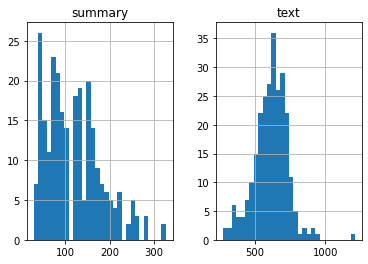

In [25]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

### Check how long the summary needs to be, so we lose less data

In [26]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=910):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9846743295019157


### Check the same for the text length

In [21]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=390):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

1.0


In [27]:
max_len_text=910
max_len_summary=390
embedding_dim = 20
latent_dim = 250

In [23]:
max_len_text=143
max_len_summary=14
embedding_dim = 300
latent_dim = 400

##### Define a batch size

In [28]:
batch_size = 4

In [29]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [30]:
from sklearn.model_selection import train_test_split
x_tr_str,x_val_str,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.001,random_state=0,shuffle=True)

In [31]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=10000)
x_tokenizer.fit_on_texts(list(x_tr_str))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr_str) 
x_val   =   x_tokenizer.texts_to_sequences(x_val_str)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [32]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer(num_words=10000)
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

### Delete empty summaries

In [33]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

print(f"Length of rows was: {len(x_tr)}")
y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)
print(f"Length of rows is: {len(x_tr)}")

Length of rows was: 260
Length of rows is: 260


In [34]:
from tensorflow.keras import backend as K 
K.clear_session() 

# Encoder 
encoder_inputs = Input(batch_input_shape=(None, max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(batch_input_shape=(None, None,)) 
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 910)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 910, 20)      186100      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 910, 250), ( 271000      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [35]:
import pydot_ng

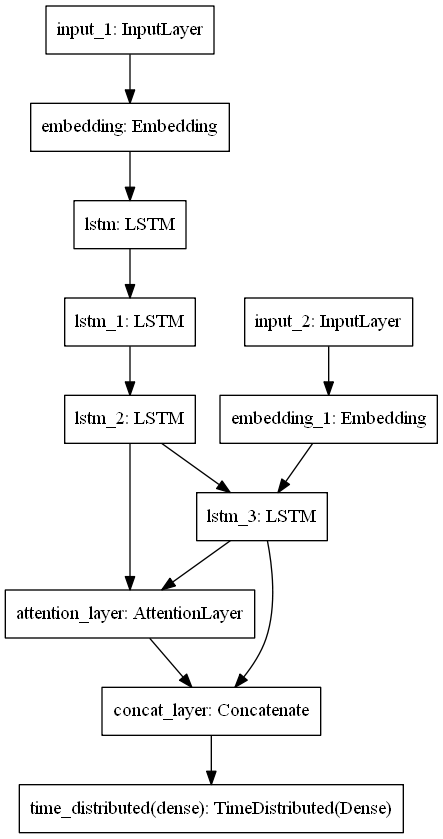

In [36]:
tf.keras.utils.plot_model(model)

In [37]:
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [38]:
es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.002, verbose=1)

In [39]:
def text_to_sequence(text):
    text_tokenized = x_tokenizer.texts_to_sequences([text])
    #padding zero upto maximum length
    text_padded = pad_sequences(text_tokenized, maxlen=max_len_text, padding='post')
    return text_padded

def reverse_seq(seq):
    out_seq = [seq[i] for i in range(len(seq) -1, -1, -1)]
    return seq

def prepareDataSetTrain(x_tr, y_tr):
    amount_x_tr_cuddn_fix = len(x_tr)-(len(x_tr) % batch_size)
    x_tr = x_tr[:amount_x_tr_cuddn_fix]
    x_tr = [reverse_seq(review_int) for review_int in [l for l in x_tr]]
    y_tr = y_tr[:amount_x_tr_cuddn_fix]
    print(len(x_tr) % batch_size)
    print(len(y_tr) % batch_size)
    dataset_x_input = tf.data.Dataset.from_tensor_slices(x_tr)
    dataset_x_context = tf.data.Dataset.from_tensor_slices(y_tr[:,:-1])
    dataset_y = tf.data.Dataset.from_tensor_slices(y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:])
    dataset_x = tf.data.Dataset.from_tensor_slices(x_tr)
    dataset_train = tf.data.Dataset.zip((dataset_x_input, dataset_x_context))
    dataset_train = tf.data.Dataset.zip((dataset_train, dataset_y))
    dataset_train_batched = dataset_train.batch(batch_size)
    return dataset_train_batched

def prepareDataPredict(sentence):
    sentence = text_cleaner(sentence)
    sentence = summary_cleaner(sentence)
    print(sentence)
    texts = []
    text_padded = text_to_sequence(sentence)
    texts.append(tf.convert_to_tensor(text_padded[0]))
    #for i in range(batch_size - 1):
    #    texts.append(tf.convert_to_tensor(text_to_sequence(sentence)[0]))
       
    #print(texts)
    data_out = tf.convert_to_tensor(texts)
    #dataset_predict = tf.data.Dataset.from_tensor_slices(texts)
   # dataset_predict_out = dataset_predict.batch(batch_size)
    #return dataset_predict_out
    return data_out

In [40]:
dataset_train_batched = prepareDataSetTrain(x_tr, y_tr)

0
0


In [41]:
val_per = 0.1
len_ds = 0
# Count the items in the dataset
for i in dataset_train_batched:
    len_ds = len_ds+1
    
# The last batch might not be full, so it will be discarded through casted into integer
max_len_ds = len_ds
len_split = int(max_len_ds * val_per)
train_amount = max_len_ds - len_split
len_split = len_split -1

In [37]:
batch_size*5

20

In [38]:
train_amount

59

In [42]:
history=model.fit(dataset_train_batched.take(train_amount), epochs=10,callbacks=[es], batch_size=batch_size, validation_data=dataset_train_batched.skip(train_amount).take(len_split))

Epoch 1/10
 1/59 [..............................] - ETA: 0s - loss: 8.0331 - accuracy: 0.0000e+00

InternalError:    Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 20, 250, 1, 910, 4, 250] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[PartitionedCall_3]] [Op:__inference_train_function_13679]

Function call stack:
train_function -> train_function -> train_function


KeyError: 'val_loss'

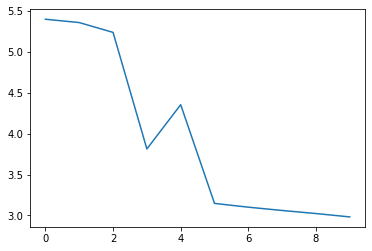

In [87]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [88]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [89]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(batch_input_shape=(None, latent_dim,))
decoder_state_input_c = Input(batch_input_shape=(None, latent_dim,))
decoder_hidden_state_input = Input(batch_input_shape=(None,max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [90]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print(e_out.shape)
    print(e_h.shape)
    print(e_c.shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostock']

    print(np.array(target_seq).shape)
    print(e_out.shape)
    print(e_h.shape)
    print(e_c.shape)
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([[target_seq] + [e_out, e_h, e_c]])
        output_tokens = output_tokens[:1]
        h_1 = h[:1]
        c_1 = c[:1]
        # Sample a token
        #Use a random choice as described in this stackoverflow solution:
        #https://stackoverflow.com/questions/47125723/keras-lstm-for-text-generation-keeps-repeating-a-line-or-a-sequence
        #sampled_token_index = np.argmax(output_tokens[0, -1, :])
        prediction_output = output_tokens[0,-1,:]
        print(output_tokens)
        sampled_token_index = np.random.choice(len(prediction_output), p=prediction_output)
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostock'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostock' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [91]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostock']) and i!=target_word_index['eostock']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [92]:
text_predict = "I just bought that gaming computer weeks ago. I am really satisfied. It is working absolutely well, no crashes. It just was a bit expensive and it would be cooler if it could cost less"
dataset_predict = prepareDataPredict(text_predict)

bought gaming computer weeks ago really satisfied working absolutely well crashes bit expensive would cooler could cost less 


In [93]:
stri = x_val_str[:1]

In [94]:
stri.array[0]

'sostock thought times morning daily west coast new york nearly noon received today paper yet left wireless night reading kindle content morning standard eostock sostock month free trial well worth try say front second nyt great paper gotten newspapers due wanting cut amount trash generate got tired excessive advertising blah blah blah getting nyt wake morning remembering missing spending minutes per morning reading parts find interesting good stuff probably continue trial said agree price tad high would much comfortable less per month considering much stripped also someone nyt read bridge column last week made numerous references missing diagram understand leaving pictures vital pictures never left going leave pictures think static pictures left bridge column without diagrams pointless added items strip include diagrams good science section far miss crossword even crossword interactive would love see grid paper nyt really close think little care could something less frustrating send d

In [95]:
for i in range(1):
  print("Review:", text_predict)
  print("Predicted summary:",decode_sequence(dataset_predict))
  print("\n")

Review: I just bought that gaming computer weeks ago. I am really satisfied. It is working absolutely well, no crashes. It just was a bit expensive and it would be cooler if it could cost less
(1, 910, 250)
(1, 250)
(1, 250)
(1, 1)
(1, 910, 250)
(1, 250)
(1, 250)
[[[0.275522   0.05380823 0.03824576 0.02319334 0.0083356  0.00801293
   0.0305444  0.01025052 0.00787585 0.00782457 0.00467978 0.00377785
   0.00423412 0.00828603 0.01395827 0.00336623 0.00400488 0.01364194
   0.00268627 0.01414722 0.00591741 0.00623748 0.00268858 0.00609476
   0.00408958 0.00341213 0.00672192 0.00366413 0.00555404 0.00701481
   0.00892761 0.0009816  0.00320845 0.00493251 0.0016907  0.0019853
   0.00448255 0.00638017 0.00337331 0.00603844 0.00192085 0.00234279
   0.00183283 0.00173488 0.00087182 0.00165002 0.00210907 0.00550536
   0.00220721 0.00149801 0.00273175 0.00268432 0.0035724  0.00165483
   0.00301164 0.00277151 0.00202057 0.00320854 0.00287156 0.00344644
   0.00396603 0.00305504 0.00127488 0.00295566 

KeyError: 0

In [95]:
for i in range(1):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(prepareDataPredict(stri.array[0])))
  print("\n")

Review: product delivered timely manner tortillas good bread taste color slightly white quite like ones used get store good product 
Original summary: tortillas by 
product delivered timely manner tortillas good bread taste color slightly white quite like ones used get store good product 
(1, 100, 300)
(1, 300)
(1, 300)
(1, 1)
(1, 100, 300)
(1, 300)
(1, 300)
[[[2.2644293e-05 7.5475391e-08 2.7483539e-04 ... 8.7105761e-08
   8.3369898e-08 8.0078081e-08]]]
[[[1.01679805e-04 1.65739120e-08 3.51383299e-01 ... 1.85767401e-08
   1.73242132e-08 1.60601878e-08]]]
[[[3.32233431e-05 1.27029605e-08 7.60188401e-01 ... 1.21570913e-08
   1.27567885e-08 1.48972816e-08]]]
[[[4.3308144e-05 1.8223499e-08 5.3989542e-01 ... 1.9247924e-08
   1.9651830e-08 1.9543803e-08]]]
[[[3.4625624e-05 3.9244668e-08 5.8780092e-01 ... 3.9935887e-08
   4.4245066e-08 4.4784127e-08]]]
[[[5.6441397e-05 6.7091235e-09 8.0218720e-01 ... 6.5757688e-09
   7.5332043e-09 7.3668014e-09]]]
Predicted summary:  tasty buy apples spice la

In [51]:
# predict something
text = "The gaming computer is a very cool one. I can do alot of stuff with it, just sometimes, it gets too warm"
text = text_to_sequence(text)


In [52]:
text

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
len(text[0])

80

In [44]:
decode_sequence(text[0].reshape(1,max_len_text))

' good the but it tea the too the but'